In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from scipy.interpolate import interp1d
import pickle
import h5py
import shutil

import sys
# sys.path.insert(0, 'brixs-main/')
sys.path.append(str(Path(r'~/brixs').expanduser()))
import brixs as br
import brixs.beamlines.id32 as id32
import brixs.addons.fitting
import brixs.model

#get_ipython().run_line_magic('matplotlib', 'qt5')
# plt.ion()

# br.settings.FIGURE_POSITION = (283, 567)
# br.get_window_position()

%matplotlib widget

TOP = Path(r'sc5699')

In [2]:
def save_spectra(obj, filename, outdir="out_spectra"):
    """
    Save a Spectra object to a .pkl file inside outdir.
    
    Args:
        obj: brixs.Spectra object
        filename (str): name of the file (e.g. "emap_20K_LH.pkl")
        outdir (str or Path): output folder (default: "out_spectra")
    """
    outdir = Path(outdir)
    outdir.mkdir(parents=True, exist_ok=True)
    filepath = outdir / filename
    
    with open(filepath, "wb") as f:
        pickle.dump(obj, f)
    
    print(f"Saved to {filepath}")

In [3]:
def load_spectra(filename, outdir="out_spectra"):
    """
    Load a Spectra object from a .pkl file inside outdir.
    
    Args:
        filename (str): name of the file (e.g. "emap_20K_LH.pkl")
        outdir (str or Path): folder where file is stored (default: "out_spectra")
    """
    filepath = Path(outdir) / filename
    if not filepath.exists():
        raise FileNotFoundError(f"File not found: {filepath}")
    
    with open(filepath, "rb") as f:
        obj = pickle.load(f)
    
    print(f"Loaded from {filepath}")
    return obj

# XAS

## LH

In [303]:
samples  = ['sample_01', 'sample_02', 'sample_03', 'sample_04', 'sample_05', 'sample_06', 'sample_07']
datasets = ['sample_01_XAS_LD_20deg_0003', 'sample_02_XAS_LD_20deg', 'sample_03_XAS_LD_20deg', 'sample_04_XAS_LD_20deg', 'sample_05_XAS_LD_20deg', 'sample_06_XAS_LD_20deg', 'sample_07_XAS_LD_20deg']

ss_LH_TEY = br.Spectra()
ss_LH_TFY = br.Spectra()

for i, (sample, dataset) in enumerate(zip(samples, datasets)):
    scan = 1 if i == 4 else 1
    spectra = id32.read(TOP, sample, dataset, scan)

    spectra[0].label = f"{sample}, {spectra[0].pol}, TFY"
    spectra[1].label = f"{sample}, {spectra[1].pol}, TEY"

    ss_LH_TEY.append(spectra[0])
    ss_LH_TFY.append(spectra[1])

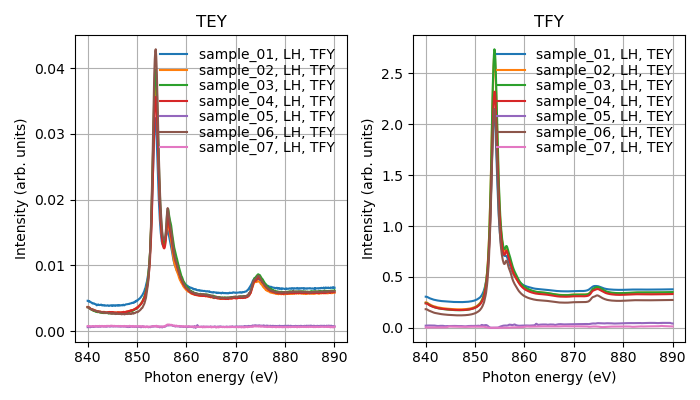

In [305]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4), sharex=True)

ss_LH_TEY.plot(ax=axes[0])
br.leg(ax=axes[0])
br.labels.xas(ax=axes[0])
axes[0].set_title("TEY")

ss_LH_TFY.plot(ax=axes[1])
br.leg(ax=axes[1])
br.labels.xas(ax=axes[1])
axes[1].set_title("TFY")

plt.tight_layout()
plt.show()

## LV

In [306]:
samples  = ['sample_01', 'sample_02', 'sample_03', 'sample_04', 'sample_05', 'sample_06', 'sample_07']
datasets = ['sample_01_XAS_LD_20deg_0003', 'sample_02_XAS_LD_20deg', 'sample_03_XAS_LD_20deg', 'sample_04_XAS_LD_20deg', 'sample_05_XAS_LD_20deg', 'sample_06_XAS_LD_20deg', 'sample_07_XAS_LD_20deg']

i = 0
ss_LV_TEY = br.Spectra()
ss_LV_TFY = br.Spectra()

for i, (sample, dataset) in enumerate(zip(samples, datasets)):
    scan = 9 if i in (4, 6) else 3
    spectra = id32.read(TOP, sample, dataset, scan)

    spectra[0].label = f"{sample}, {spectra[0].pol}, TFY"
    spectra[1].label = f"{sample}, {spectra[1].pol}, TEY"

    ss_LV_TEY.append(spectra[0])
    ss_LV_TFY.append(spectra[1])

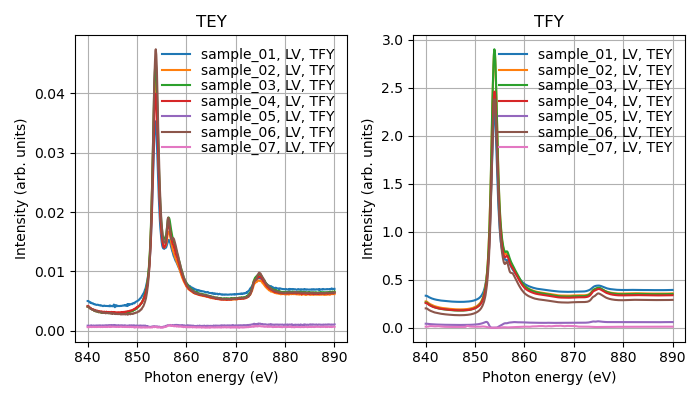

In [307]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4), sharex=True)

ss_LV_TEY.plot(ax=axes[0])
br.leg(ax=axes[0])
br.labels.xas(ax=axes[0])
axes[0].set_title("TEY")

ss_LV_TFY.plot(ax=axes[1])
br.leg(ax=axes[1])
br.labels.xas(ax=axes[1])
axes[1].set_title("TFY")

plt.tight_layout()
plt.show()

# Quick energy maps

## Sample 1

### LH

In [11]:
sample  = 'sample_01'
dataset = 'sample_01_quick_energy_dependence_LH'
scans   = np.arange(1, 9)

ss = br.Spectra()
for scan in scans:
    if scan ==1: s = id32.read(TOP, sample, dataset, scan, subscan=2)
    else: s = id32.read(TOP, sample, dataset, scan, subscan=1)
    s.label = f'{sample}, {np.round(s.metadata['E'], 2)} eV, {s.pol}'
    ss.append(s)

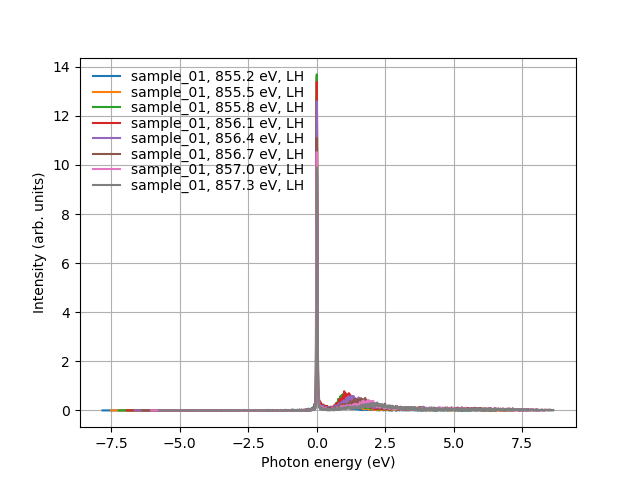

In [12]:
br.figure()
ss.plot()
br.labels.xas()
br.leg(loc='upper left')

In [13]:
ss2 = ss.floor(limits=(-6, -2))
# br.figure()
# _=ss2.plot()

In [16]:
ss3 = ss2.interp().align(mode='peak', limits=(-0.2, 0.2))
# br.figure()
# br.labels.rixs()
# _ = ss3.plot()

In [17]:
save_spectra(ss3, "sample1_emap_LH.pkl")

Saved to out_spectra/sample1_emap_LH.pkl


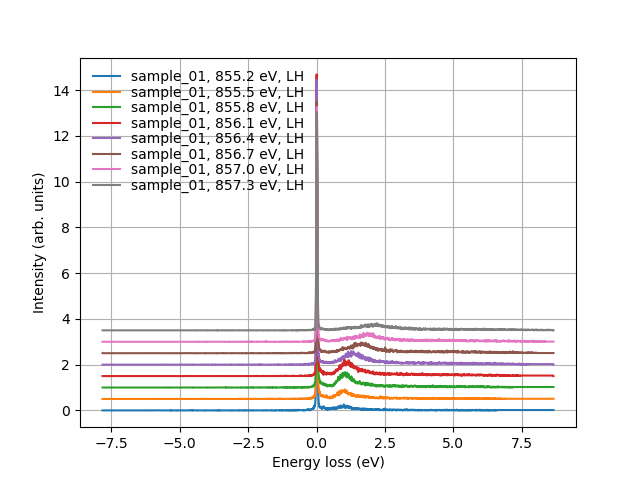

In [30]:
br.figure()
offset_step = 0.5
ax = plt.gca()

for i, s in enumerate(ss3):
    offset = i * offset_step
    ax.plot(s.x, s.y + offset, label=s.label)

br.labels.rixs()
br.leg(loc="upper left")

In [31]:
im = ss3.interp().stack_spectra_as_columns()
im.x_centers = [_.metadata['E'] for _ in ss3]
# br.figure(figsize=(10, 30))
# br.figure()
# im.pcolormesh(vmin=0, vmax=100)
# im.pcolormesh()
# br.labels.energy_map()
# plt.ylim([-0.2, 6])

In [32]:
new_E = np.linspace(
    min(im.x_centers) - 0.5,
    max(im.x_centers) + 0.5,
    100
)

data_interp = np.zeros((im.data.shape[0], len(new_E)))

for i in range(im.data.shape[0]):
    f = interp1d(im.x_centers, im.data[i, :],
                 kind="linear", fill_value="extrapolate")
    data_interp[i, :] = f(new_E)

im_interp = im.copy()
im_interp.data = data_interp
im_interp.x_centers = new_E
im_interp.y_centers = im.y_centers

In [33]:
# br.figure()
# im_interp.pcolormesh(vmin=0, vmax=100)
# br.labels.energy_map()
# plt.ylim([-0.2, 6])

(-0.2, 6.0)

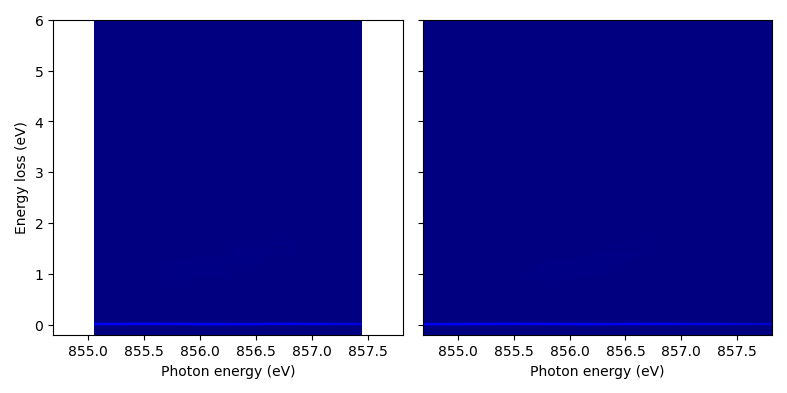

In [34]:
fig, axes = br.subplots(1, 2, sharey=True, sharex=True, figsize=(20, 10), wspace=0.5, layout='tight')

im.pcolormesh(vmin=0, vmax=100, ax = axes[0])
im_interp.pcolormesh(vmin=0, vmax=100, ax = axes[1])

br.labels.energy_map(ax = axes[0])
br.labels.energy_map(ax = axes[1])
axes[1].remove_ylabel()
plt.ylim([-0.2, 6])

### LV

In [2]:
sample  = 'sample_01'
dataset = 'sample_01_quick_energy_dependence_LV'
scans   = np.arange(1, 9)

ss = br.Spectra()
for scan in scans:
    if scan ==1: s = id32.read(TOP, sample, dataset, scan, subscan=2)
    else: s = id32.read(TOP, sample, dataset, scan, subscan=1)
    s.label = f'{sample}, {np.round(s.metadata['E'], 2)} eV, {s.pol}'
    ss.append(s)

In [3]:
# br.figure()
# br.labels.rixs()
# ss.plot()
# br.leg()

In [4]:
ss2 = ss.floor(limits=(-6, -2))
# br.figure()
# br.labels.rixs()
# _=ss2.plot()

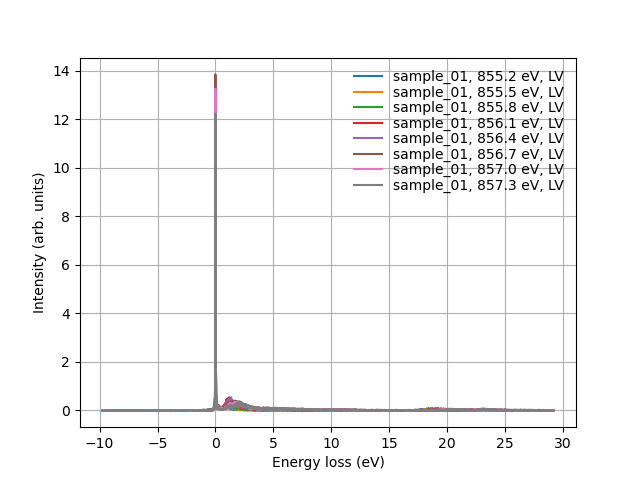

In [6]:
ss3 = ss2.interp().align(mode='peak', limits=(-0.2, 0.2)).set_shift(-0.0072)
br.figure()
br.labels.rixs()
_ = ss3.plot()
br.leg()

In [10]:
save_spectra(ss3, "sample1_emap_LV.pkl")

Saved to out_spectra/sample1_emap_LV.pkl


## Sample 2

### LH

In [75]:
sample  = 'sample_02'
dataset = 'sample_02_quick_energy_dependence_LH'
scans   = np.arange(1, 9)

ss = br.Spectra()
for scan in scans:
    if scan ==1: s = id32.read(TOP, sample, dataset, scan, subscan=2)
    else: s = id32.read(TOP, sample, dataset, scan, subscan=1)
    s.label = f'{sample}, {np.round(s.metadata['E'], 2)} eV, {s.pol}'
    ss.append(s)

In [76]:
# br.figure()
# ss.plot()
ss2 = ss.floor(limits=(-6, -2))
# br.figure()
# _=ss2.plot()
# br.labels.xas()
# br.leg(loc='upper left')

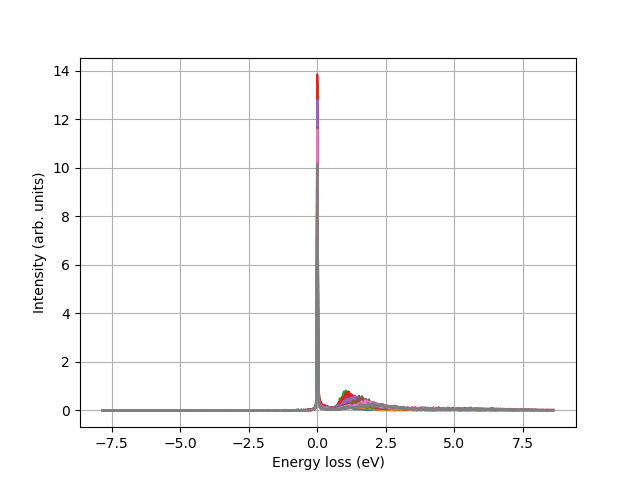

In [77]:
ss3 = ss2.interp().align(mode='peak', limits=(-0.2, 0.2)).set_shift(-0.0035)
br.figure()
_ = ss3.plot()
br.labels.rixs()

In [31]:
save_spectra(ss3, "sample2_emap_LH.pkl")

Saved to out_spectra/sample2_emap_LH.pkl


In [31]:
im = ss3.interp().stack_spectra_as_columns()
im.x_centers = [_.metadata['E'] for _ in ss3]
# br.figure(figsize=(10, 30))
# br.figure()
# im.pcolormesh(vmin=0, vmax=100)
# im.pcolormesh()
# br.labels.energy_map()
# plt.ylim([-0.2, 6])

new_E = np.linspace(
    min(im.x_centers) - 0.5,
    max(im.x_centers) + 0.5,
    100
)

data_interp = np.zeros((im.data.shape[0], len(new_E)))

for i in range(im.data.shape[0]):
    f = interp1d(im.x_centers, im.data[i, :],
                 kind="linear", fill_value="extrapolate")
    data_interp[i, :] = f(new_E)

im_interp = im.copy()
im_interp.data = data_interp
im_interp.x_centers = new_E
im_interp.y_centers = im.y_centers

(-0.2, 6.0)

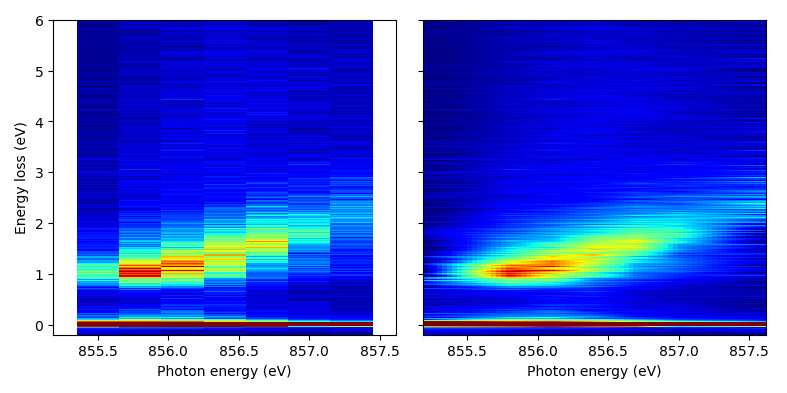

In [34]:
fig, axes = br.subplots(1, 2, sharey=True, sharex=True, figsize=(20, 10), wspace=0.5, layout='tight')

im.pcolormesh(vmin=0, vmax=100, ax = axes[0])
im_interp.pcolormesh(vmin=0, vmax=100, ax = axes[1])

br.labels.energy_map(ax = axes[0])
br.labels.energy_map(ax = axes[1])
axes[1].remove_ylabel()
plt.ylim([-0.2, 6])

### LV

In [564]:
sample  = 'sample_02'
dataset = 'sample_02_quick_energy_dependence_LV'
scans   = np.arange(1, 9)

ss = br.Spectra()
for scan in scans:
    if scan ==1: s = id32.read(TOP, sample, dataset, scan, subscan=2)
    else: s = id32.read(TOP, sample, dataset, scan, subscan=1)
    s.label = f'{sample}, {np.round(s.metadata['E'], 2)} eV, {s.pol}'
    ss.append(s)

In [565]:
# br.figure()
# ss.plot()
ss2 = ss.floor(limits=(-6, -2))
# br.figure()
# _=ss2.plot()
# br.labels.xas()
# br.leg(loc='upper left')

In [567]:
ss3 = ss2.interp().align(mode='peak', limits=(-0.2, 0.2)).set_shift(-0.0026)
# br.figure()
# _ = ss3.plot()
# br.labels.rixs()

In [37]:
save_spectra(ss3, "sample2_emap_LV.pkl")

Saved to out_spectra/sample2_emap_LV.pkl


## Plot

In [8]:
quick_emaps = {
    1: {'LH': load_spectra("sample1_emap_LH.pkl"),
        'LV': load_spectra("sample1_emap_LV.pkl")},
    2: {'LH': load_spectra("sample2_emap_LH.pkl"),
        'LV': load_spectra("sample2_emap_LV.pkl")},
    3: {'LH': load_spectra("sample3_emap_LH.pkl"),
        'LV': load_spectra("sample3_emap_LV.pkl")},
    4: {'LH': load_spectra("sample4_emap_LH.pkl"),
        'LV': load_spectra("sample4_emap_LV.pkl")},
    5: {'LH': load_spectra("sample5_emap_LH.pkl"),
        'LV': 0},
    6: {'LH': load_spectra("sample6_emap_LH.pkl"),
        'LV': load_spectra("sample6_emap_LV.pkl")},
    7: {'LH': load_spectra("sample7_emap_LH.pkl"),
        'LV': 0},
}

Loaded from out_spectra/sample1_emap_LH.pkl
Loaded from out_spectra/sample1_emap_LV.pkl
Loaded from out_spectra/sample2_emap_LH.pkl
Loaded from out_spectra/sample2_emap_LV.pkl
Loaded from out_spectra/sample3_emap_LH.pkl
Loaded from out_spectra/sample3_emap_LV.pkl
Loaded from out_spectra/sample4_emap_LH.pkl
Loaded from out_spectra/sample4_emap_LV.pkl
Loaded from out_spectra/sample5_emap_LH.pkl
Loaded from out_spectra/sample6_emap_LH.pkl
Loaded from out_spectra/sample6_emap_LV.pkl
Loaded from out_spectra/sample7_emap_LH.pkl


In [9]:
ims_dict = {}
ims_interp_dict = {}

for key, sample in quick_emaps.items():
    ims_dict[key] = {}
    ims_interp_dict[key] = {}

    for branch in ['LH', 'LV']:
        if branch not in sample:
            continue
        if not isinstance(sample[branch], br.Spectra):
            continue

        im = sample[branch].interp().stack_spectra_as_columns()
        im.x_centers = [_.metadata['E'] for _ in sample[branch]]
        ims_dict[key][branch] = im

        step_x = np.median(np.diff(im.x_centers))
        step_y = np.median(np.diff(im.y_centers))
        
        new_Y = np.linspace(min(im.y_centers) - step_y, 
                            max(im.y_centers) + step_y, len(im.y_centers)*2)
        
        data_y_interp = np.zeros((len(new_Y), im.data.shape[1]))
        for j in range(im.data.shape[1]):
            f = interp1d(im.y_centers, im.data[:, j], kind="linear", fill_value="extrapolate")
            data_y_interp[:, j] = f(new_Y)
        
        new_E = np.linspace(min(im.x_centers) - step_x,
                            max(im.x_centers) + step_x,
                            len(im.x_centers)*10)
        
        data_interp = np.zeros((len(new_Y), len(new_E)))
        for i in range(len(new_Y)): 
            f = interp1d(im.x_centers, data_y_interp[i, :],
                         kind="linear", fill_value="extrapolate")
            data_interp[i, :] = f(new_E)

        im_interp = im.copy()
        im_interp.data = data_interp
        im_interp.x_centers = new_E
        im_interp.y_centers = new_Y
        ims_interp_dict[key][branch] = im_interp

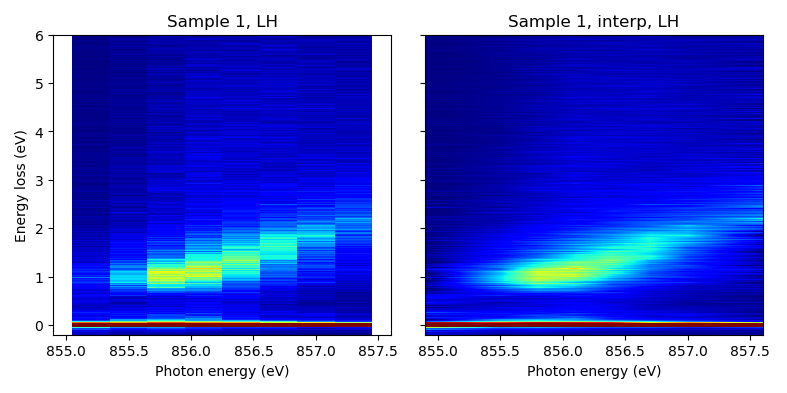

In [7]:
fig, axes = br.subplots(1, 2, sharey=True, sharex=True, figsize=(20, 10), wspace=0.5, layout='tight')

ims_dict[1]['LH'].pcolormesh(vmin=0, vmax=1, ax=axes[0])
br.labels.energy_map(ax=axes[0])
axes[0].set_title('Sample 1, LH')

ims_interp_dict[1]['LH'].pcolormesh(vmin=0, vmax=1, ax=axes[1])
br.labels.energy_map(ax=axes[1])
axes[1].set_title('Sample 1, interp, LH')

axes[1].set_ylabel('')  

plt.ylim([-0.2, 6])
plt.show()

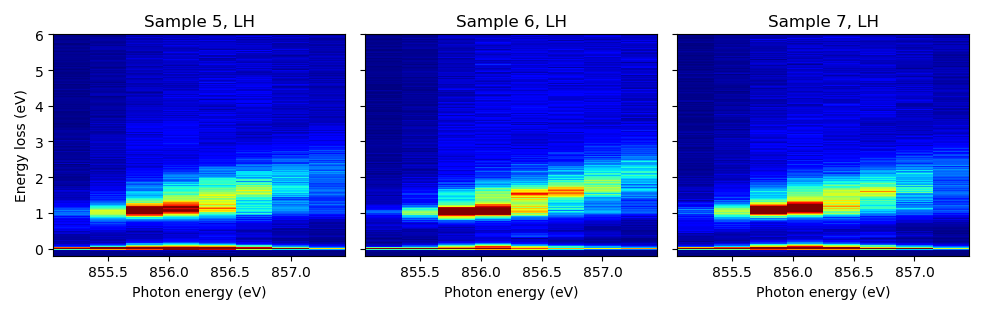

In [13]:
fig, axes = br.subplots(1, 3, sharey=True, sharex=True, figsize=(25, 8), wspace=0.5, layout='tight')

ims_dict[5]['LH'].pcolormesh(vmin=0, vmax=1, ax=axes[0])
br.labels.energy_map(ax=axes[0])
axes[0].set_title('Sample 5, LH')

ims_dict[6]['LH'].pcolormesh(vmin=0, vmax=1, ax=axes[1])
br.labels.energy_map(ax=axes[1])
axes[1].set_title('Sample 6, LH')

ims_dict[7]['LH'].pcolormesh(vmin=0, vmax=1, ax=axes[2])
br.labels.energy_map(ax=axes[2])
axes[2].set_title('Sample 7, LH')

axes[1].set_ylabel('')  
axes[2].set_ylabel('') 

plt.ylim([-0.2, 6])
plt.show()

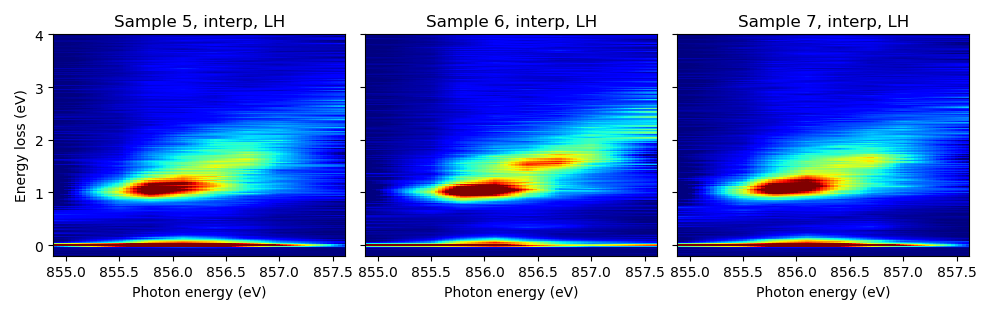

In [14]:
fig, axes = br.subplots(1, 3, sharey=True, sharex=True, figsize=(25, 8), wspace=0.5, layout='tight')

ims_interp_dict[5]['LH'].pcolormesh(vmin=0, vmax=1, ax=axes[0])
br.labels.energy_map(ax=axes[0])
axes[0].set_title('Sample 5, interp, LH')

ims_interp_dict[6]['LH'].pcolormesh(vmin=0, vmax=1, ax=axes[1])
br.labels.energy_map(ax=axes[1])
axes[1].set_title('Sample 6, interp, LH')

ims_interp_dict[7]['LH'].pcolormesh(vmin=0, vmax=1, ax=axes[2])
br.labels.energy_map(ax=axes[2])
axes[2].set_title('Sample 7, interp, LH')

axes[1].set_ylabel('')  
axes[2].set_ylabel('') 

plt.ylim([-0.2, 4])
plt.show()

# Sample 4 q dependent RIXS

## q dependent RIXS at tth 90° h0 direction

### hk 0.06 0

In [7]:
sample  = 'sample_04'
dataset = 'sample_04_rixs_sample4_h0p06k0_90deg'
scans   = np.arange(1, 9)

sample2  = 'sample_04'
dataset2 = 'sample_04_rixs_sample4_h0p06k0_90deg_0002'
scans2   = np.arange(1, 5)

ss = br.Spectra()
for scan in scans:
    if scan ==1: s = id32.read(TOP, sample, dataset, scan, subscan=2)
    else: s = id32.read(TOP, sample, dataset, scan, subscan=1)
    s.label = f'{sample}, {np.round(s.metadata['E'], 2)} eV, {s.pol}, th {s.metadata['th']}, phi {s.metadata['phi']}'
    ss.append(s)

for scan in scans2:
    if scan ==1: s = id32.read(TOP, sample2, dataset2, scan, subscan=2)
    else: s = id32.read(TOP, sample2, dataset2, scan, subscan=1)
    s.label = f'{sample}, {np.round(s.metadata['E'], 2)} eV, {s.pol}, th {s.metadata['th']}, phi {s.metadata['phi']}'
    ss.append(s)

In [8]:
# br.figure()
# ss.plot()
# br.labels.rixs()
# br.leg()

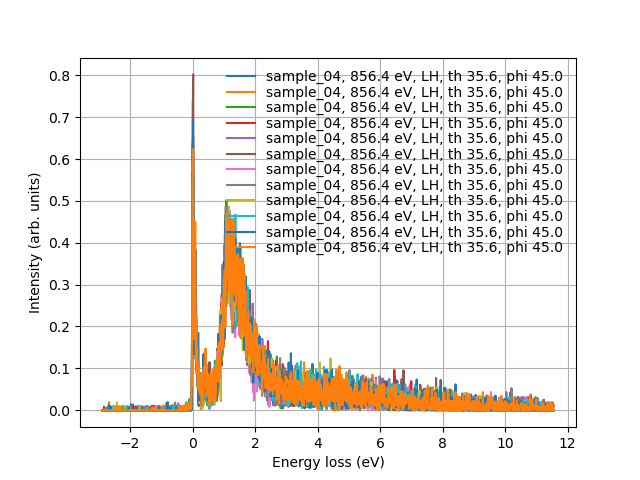

In [9]:
ss2 = ss.floor(limits=(-3, -1))
# br.figure()
# _=ss2.plot()
# br.labels.xas()
# br.leg(loc='upper left')
ss3 = ss2.align(mode='peak', limits=(-0.3, 0.5)).interp()
br.figure()
_ = ss3.plot()
br.labels.rixs()
# br.leg()

In [407]:
ss_ave = ss3.calculate_average()
ss_ave.label = f'(h, k) = (0.06, 0), {sample}'
save_spectra(ss_ave, "sample4_h0p06k0.pkl")

### hk ......

# Sample 1 q dependent RIXS

## q dependent RIXS at tth 90° h0 direction

### hk 0.06 0

In [14]:
sample  = 'sample_01'
dataset = 'sample_01_rixs_sample1_h0p06k0_90deg'
scans   = np.arange(1, 9)

sample2  = 'sample_01'
dataset2 = 'sample_01_rixs_sample1_h0p06k0_90deg_0003'
scans2   = np.arange(1, 5)

ss = br.Spectra()
for scan in scans:
    if scan ==1: s = id32.read(TOP, sample, dataset, scan, subscan=2)
    else: s = id32.read(TOP, sample, dataset, scan, subscan=1)
    s.label = f'{sample}, {np.round(s.metadata['E'], 2)} eV, {s.pol}, th {s.metadata['th']}'
    ss.append(s)

for scan in scans2:
    if scan ==1: s = id32.read(TOP, sample2, dataset2, scan, subscan=2)
    else: s = id32.read(TOP, sample2, dataset2, scan, subscan=1)
    s.label = f'{sample}, {np.round(s.metadata['E'], 2)} eV, {s.pol}, th {s.metadata['th']}, phi {s.metadata['phi']}'
    ss.append(s)

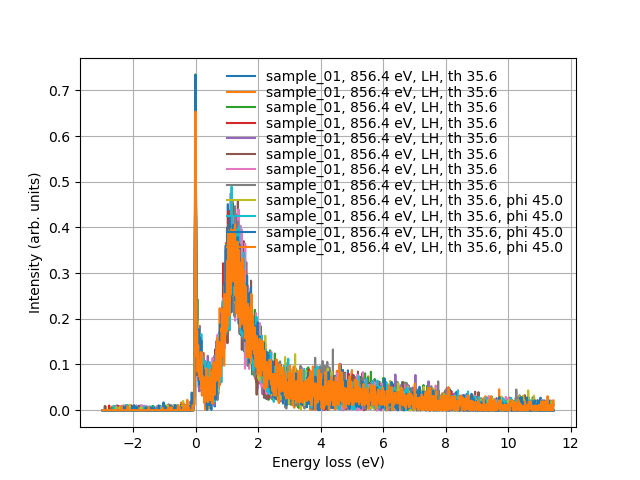

In [16]:
ss2 = ss.floor(limits=(-3, -1))
# br.figure()
# _=ss2.plot()
# br.labels.xas()
# br.leg(loc='upper left')
ss3 = ss2.align(mode='peak', limits=(-0.3, 0.05)).interp()
br.figure()
_ = ss3.plot()
#ss_add_up_h0p06k0.plot()
br.labels.rixs()
# plt.xlim([-0.05, 0.15])
# plt.ylim([-0.1, 4])
br.leg()

In [482]:
ss_ave = ss3.calculate_average()
ss_ave.label = f'(h, k) = (0.06, 0), {sample}'
save_spectra(ss_ave, "sample1_h0p06k0.pkl")

Saved to out_spectra/sample1_h0p06k0.pkl


### hk ......

# Sample 2 ......

# Sample 3 ......

# q dependency plot

### Load data

In [10]:
qdep_s4 = {}

qdep_s4[(0, 0)]  = load_spectra("sample4_hk0.pkl")
qdep_s4[(0.06, 0.0)]  = load_spectra("sample4_h0p06k0.pkl")
qdep_s4[(0.10, 0.0)]  = load_spectra("sample4_h0p1k0.pkl")
qdep_s4[(0.14, 0.0)]  = load_spectra("sample4_h0p14k0.pkl")
qdep_s4[(0.18, 0.0)]  = load_spectra("sample4_h0p18k0.pkl")
qdep_s4[(0.21, 0.0)]  = load_spectra("sample4_h0p21k0.pkl")
qdep_s4[(0.235, 0.0)] = load_spectra("sample4_h0p235k0.pkl")

qdep_s4[(0.042, 0.042)] = load_spectra("sample4_hk0p042.pkl")
qdep_s4[(0.071, 0.071)] = load_spectra("sample4_hk0p071.pkl")
qdep_s4[(0.10, 0.10)]  = load_spectra("sample4_hk0p1.pkl")
qdep_s4[(0.127, 0.127)] = load_spectra("sample4_hk0p127.pkl")
qdep_s4[(0.156, 0.156)] = load_spectra("sample4_hk0p156.pkl")

qdep_s4[(0.26, 0)]  = load_spectra("sample4_h0p26k0.pkl")
qdep_s4[(0.33, 0)] = load_spectra("sample4_h0p33k0.pkl")

Loaded from out_spectra/sample4_hk0.pkl
Loaded from out_spectra/sample4_h0p06k0.pkl
Loaded from out_spectra/sample4_h0p1k0.pkl
Loaded from out_spectra/sample4_h0p14k0.pkl
Loaded from out_spectra/sample4_h0p18k0.pkl
Loaded from out_spectra/sample4_h0p21k0.pkl
Loaded from out_spectra/sample4_h0p235k0.pkl
Loaded from out_spectra/sample4_hk0p042.pkl
Loaded from out_spectra/sample4_hk0p071.pkl
Loaded from out_spectra/sample4_hk0p1.pkl
Loaded from out_spectra/sample4_hk0p127.pkl
Loaded from out_spectra/sample4_hk0p156.pkl
Loaded from out_spectra/sample4_h0p26k0.pkl
Loaded from out_spectra/sample4_h0p33k0.pkl


In [ ]:
qdep_s1 = {}

qdep_s1[(0, 0)]  = load_spectra("sample1_hk0.pkl")
qdep_s1[(0.06, 0.0)]  = load_spectra("sample1_h0p06k0.pkl")
qdep_s1[(0.10, 0.0)]  = load_spectra("sample1_h0p1k0.pkl")
qdep_s1[(0.14, 0.0)]  = load_spectra("sample1_h0p14k0.pkl")
qdep_s1[(0.18, 0.0)]  = load_spectra("sample1_h0p18k0.pkl")
qdep_s1[(0.21, 0.0)]  = load_spectra("sample1_h0p21k0.pkl")
qdep_s1[(0.235, 0.0)] = load_spectra("sample1_h0p235k0.pkl")

qdep_s1[(0.042, 0.042)] = load_spectra("sample1_hk0p042.pkl")
qdep_s1[(0.071, 0.071)] = load_spectra("sample1_hk0p071.pkl")
qdep_s1[(0.10, 0.10)]  = load_spectra("sample1_hk0p1.pkl")
qdep_s1[(0.127, 0.127)] = load_spectra("sample1_hk0p127.pkl")
qdep_s1[(0.156, 0.156)] = load_spectra("sample1_hk0p156.pkl")

qdep_s1[(0.26, 0)]  = load_spectra("sample1_h0p26k0.pkl")
qdep_s1[(0.33, 0)] = load_spectra("sample1_h0p33k0.pkl")

In [ ]:
qdep_s2 = {}
...
qdep_s3 = {}
...

In [ ]:
shifts_s4 = {
    (0, 0):       -0.0033,
    (0.06, 0.0):  -0.0071,
    (0.10, 0.0):   0.0,
    (0.14, 0.0):  -0.0074,
    (0.18, 0.0):  -0.012,
    (0.21, 0.0):   0.0,
    (0.235, 0.0):  0.0047,
    (0.26, 0.0):   0.0,
    (0.33, 0.0):   0.0,
}

shifts_s1 = {
    (0, 0):       -0.003,
    (0.06, 0.0):   0.0,
    (0.10, 0.0):  -0.021,
    (0.14, 0.0):  -0.025+0.008,
    (0.18, 0.0):  -0.005,
    (0.21, 0.0):  -0.0049,
    (0.235, 0.0): -0.016,
    (0.26, 0.0):   0.0,
    (0.33, 0.0):   0.0,
}

shifts_s2 = {
    (0, 0):        0,
    (0.06, 0.0):   0.0,
    (0.10, 0.0):   -0.0047,
    (0.14, 0.0):   -0.008,
    (0.18, 0.0):   -0.0095,
    (0.21, 0.0):   0,
    (0.235, 0.0):  -0.034,
    (0.26, 0.0):   0.0,
    (0.33, 0.0):   0.0,
}

shifts_s3 = {
    (0, 0):        0,
    (0.06, 0.0):   0.0,
    (0.10, 0.0):   -0.00,
    (0.14, 0.0):   -0.0058,
    (0.18, 0.0):   -0.0133,
    (0.21, 0.0):   0.048,
    (0.235, 0.0):  0.0248,
    (0.26, 0.0):   0.0,
    (0.33, 0.0):   -0.0127,
}

### Plot

Loaded from out_spectra/sample4_h0p06k0_remeasured.pkl


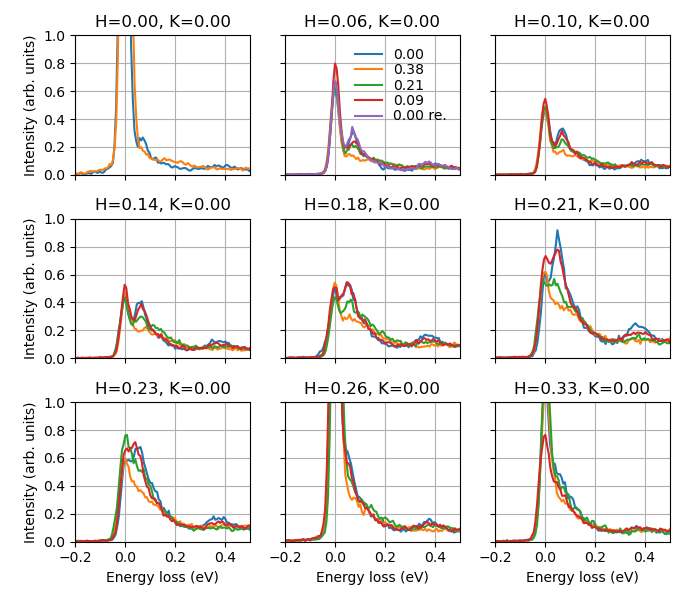

In [33]:
fig, axes = plt.subplots(3, 3, figsize=(7, 6), sharex=True, sharey=True)
axes = axes.flatten()

for ax, (hk, shift4) in zip(axes, sorted(shifts_s4.items())):

    if hk in qdep_s4:
        spec4 = qdep_s4[hk].set_shift(shift4)
        ax.plot(spec4.x, spec4.y, label="0.00")

    if hk in qdep_s1 and hk in shifts_s1:
        shift1 = shifts_s1[hk]
        spec1 = qdep_s1[hk].set_shift(shift1)
        ax.plot(spec1.x, spec1.y, label="0.38")
        
    if hk in qdep_s2 and hk in shifts_s2:
        shift2 = shifts_s2[hk]
        spec2 = qdep_s2[hk].set_shift(shift2)
        ax.plot(spec2.x, spec2.y, label="0.21")
        
    if hk in qdep_s3 and hk in shifts_s3:
        shift3 = shifts_s3[hk]
        spec3 = qdep_s3[hk].set_shift(shift3)
        ax.plot(spec3.x, spec3.y, label="0.09")

    ax.set_title(f"H={hk[0]:.2f}, K={hk[1]:.2f}")
    ax.set_xlim([-0.2, 0.5])
    ax.set_ylim([0, 1])
    br.labels.rixs(ax=ax)

br.leg(ax=axes[1], loc = 'upper right')

for ax in axes:
    ax.label_outer()

plt.tight_layout()
plt.show()